In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
import glob

In [2]:
import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing


In [3]:
from sys import path as sys_path
# Change to your local copy's location...
#sys_path.append('https://github.com/ianan/demreg/blob/master/python/dn2dem_pos.py')
sys_path.append(r'C:\Users\HP\Downloads\Sunpy\demreg\python')
from dn2dem_pos import dn2dem_pos

In [4]:
import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [5]:
from sunpy.net import Fido, attrs as a

In [6]:
wvsrch=a.Wavelength(94*u.angstrom, 335*u.angstrom)

In [7]:
print(wvsrch)

<sunpy.net.attrs.Wavelength(94.0, 335.0, 'Angstrom')>


In [8]:
result = Fido.search(a.Time('2010-11-03T12:15:09', '2010-11-03T12:15:19'), a.Instrument("aia"), wvsrch)

In [9]:
files = Fido.fetch(result,path=r'C:\Users\HP\Downloads\Sunpy')

Files Downloaded:   0%|          | 0/6 [00:00<?, ?file/s]

In [10]:
fdir = r'C:\Users\HP\Downloads\Sunpy\\'  # Note the extra backslash at the end
ff = sorted(glob.glob(fdir + 'aia*lev1*.fits'))
print(ff)

['C:\\Users\\HP\\Downloads\\Sunpy\\aia.lev1.131A_2010_11_03T12_15_09.62Z.image_lev1.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia.lev1.171A_2010_11_03T12_15_12.34Z.image_lev1.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia.lev1.193A_2010_11_03T12_15_19.84Z.image_lev1.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia.lev1.211A_2010_11_03T12_15_12.62Z.image_lev1.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia.lev1.335A_2010_11_03T12_15_15.62Z.image_lev1.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia.lev1.94A_2010_11_03T12_15_14.12Z.image_lev1.fits']


In [11]:
amaps=sunpy.map.Map(ff)

In [12]:
wvn0 = [m.meta['wavelnth'] for m in amaps]
print(wvn0)
srt_id = sorted(range(len(wvn0)), key=wvn0.__getitem__)
print(srt_id)

[131, 171, 193, 211, 335, 94]
[5, 0, 1, 2, 3, 4]


In [13]:
amaps = [amaps[i] for i in srt_id]
print([m.meta['wavelnth'] for m in amaps])

[94, 131, 171, 193, 211, 335]


In [14]:
#JSOC site is down that's why not using update_pointing
aprep=[]
for m in amaps:
    m_temp = m#update_pointing(m)
    aprep.append(register(m_temp))
print([m.meta['wavelnth'] for m in aprep])

[94, 131, 171, 193, 211, 335]


In [15]:
blo=[-1150*u.arcsec,-500*u.arcsec]
tro=[-850*u.arcsec,-200*u.arcsec]

In [16]:
suba_maps=[]
for a in aprep:
    bottom_left = SkyCoord(blo[0],blo[1], frame=a.coordinate_frame)
    top_right = SkyCoord(tro[0],tro[1], frame=a.coordinate_frame)
    suba_maps.append(a.submap(bottom_left=bottom_left, top_right=top_right))

In [17]:
suba_maps[0].data.shape

(501, 501)

In [18]:
seq=sunpy.map.Map(suba_maps[0],suba_maps[1],suba_maps[2],\
                   suba_maps[3],suba_maps[4],suba_maps[5],sequence=True,sortby=None) 
seq.save(fdir+'aia_smd_{index:03}.fits',overwrite='True')

In [19]:
ffin=sorted(glob.glob(fdir+'aia_smd_*.fits'))
print(ffin)
aprep=sunpy.map.Map(ffin)
#Print out the order just to check they are stil sorted correctly
print([m.meta['wavelnth'] for m in aprep])

['C:\\Users\\HP\\Downloads\\Sunpy\\aia_smd_000.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia_smd_001.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia_smd_002.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia_smd_003.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia_smd_004.fits', 'C:\\Users\\HP\\Downloads\\Sunpy\\aia_smd_005.fits']
[94, 131, 171, 193, 211, 335]


In [20]:
wvn = [m.meta['wavelnth'] for m in aprep]
worder=np.argsort(wvn)

durs = [m.meta['exptime'] for m in aprep]

# Convert to numpy arrays as make things easier later
durs=np.array(durs)
wvn=np.array(wvn)
print(durs)
print(wvn)

[2.901069 2.901394 2.000186 2.000083 2.90081  2.900859]
[ 94 131 171 193 211 335]


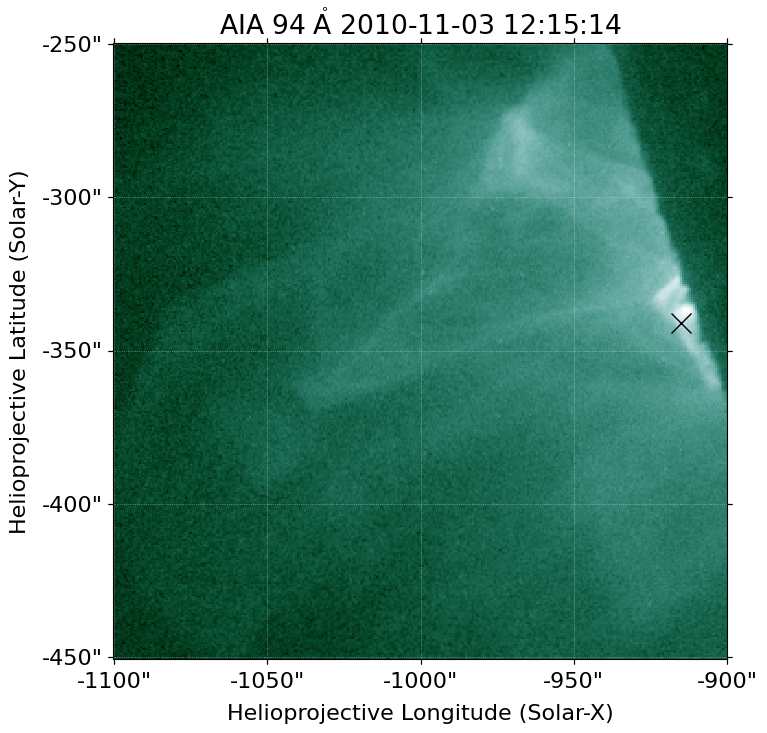

[ 418 2299 2135 5506 2624  153]


In [21]:
bottom_left = SkyCoord(-1100*u.arcsec,-450*u.arcsec, frame=aprep[0].coordinate_frame)
top_right = SkyCoord(-900*u.arcsec,-250*u.arcsec, frame=aprep[0].coordinate_frame)
mm = aprep[0].submap(bottom_left=bottom_left, top_right=top_right)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection=mm)
mm.plot()
px=-915*u.arcsec
py=-341*u.arcsec

ax.plot_coord(SkyCoord(px,py, frame=mm.coordinate_frame), 'kx', fillstyle='none', markersize=15)
plt.show()

# find the DN value at given pixel position
data=[]
for m in aprep:
    px_loc=m.world_to_pixel(SkyCoord(px,py, frame=m.coordinate_frame))
    data.append(m.data[int(px_loc[1].value),int(px_loc[0].value)])
data=np.array(data)
print(data)

In [22]:
worder=np.argsort(wvn)
print(worder)

[0 1 2 3 4 5]


In [23]:
channels = [94,131,171,193,211,335] * u.angstrom
time=atime.Time('2010-11-03T12:15:00', scale='utc')

In [24]:
#JSOC site is down that's why error is occuring, i calculated the degradation values earlier as well which i used in the below cell.
nc=len(channels)
degs=np.empty(nc)
'''for i in np.arange(nc):
      degs[i]=degradation(channels[i],time,calibration_version=10)
print(degs)'''

'for i in np.arange(nc):\n      degs[i]=degradation(channels[i],time,calibration_version=10)\nprint(degs)'

In [25]:
degs=np.array([1.14278863, 0.91401251, 0.99550979, 0.98652938, 0.97036462, 0.83094366])


In [26]:
cor_data=data/degs

In [27]:
file_path=r'C:\Users\HP\Downloads\Sunpy\demreg\python\aia_tresp_en.dat'
trin=io.readsav(file_path)

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

In [28]:
print(trin['channels'])

[b'A94' b'A131' b'A171' b'A193' b'A211' b'A335']


In [29]:
dn_in=cor_data/durs
print('dn_in: ',dn_in)

dn_in:  [ 126.08177454  866.92219662 1072.21520316 2790.47518609  932.20106177
   63.47361487]


In [30]:
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
num_pix=1
shotnoise=(dn2ph*data*num_pix)**0.5/dn2ph/num_pix/degs
# Combine errors and put into DN/px/s
edn_in=(rdnse**2+shotnoise**2)**0.5/durs
print('edn_in: ',edn_in)

edn_in:  [ 8.67498028 21.95032664 24.59035772 36.88596028 17.07403572  3.91626441]


In [31]:
temps=np.logspace(5.7,7.6,num=42)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

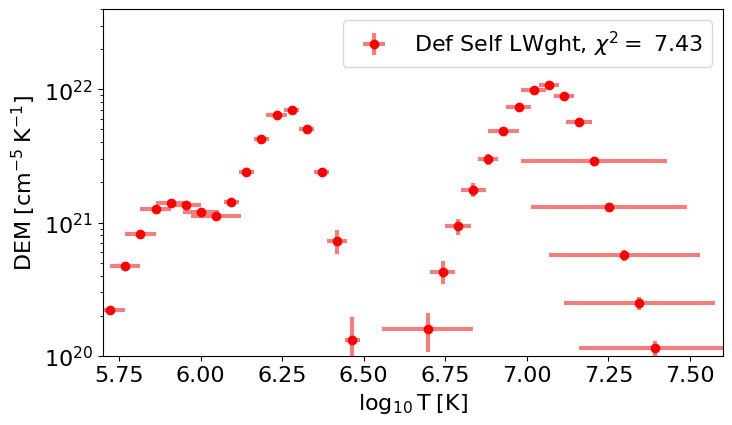

In [32]:
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps)
#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',ecolor='lightcoral', \
             elinewidth=3, capsize=0,label='Def Self LWght, $\chi^2 =$ {:0.2f}'.format(chisq0))
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([1e20,4e22])
plt.xlim([5.7,7.6])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiapxl_slw.png',bbox_inches='tight')
plt.show()



In [33]:
temps_mid = 0.5 * (temps[:-1] + temps[1:])

In [34]:
from scipy.integrate import simps

# Example: Using dem0 as the DEM result
# Integrating over temperature bins (temps) to get EM
em0 = simps(dem0, x=temps_mid)

print(f"Emission Measure (EM) for DEM0: {em0:.3e} cm⁻⁵")

Emission Measure (EM) for DEM0: 7.870e+28 cm⁻⁵
